In [ ]:
!  pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pwd

/content/drive/MyDrive


In [ ]:
#!/bin/bash
! kaggle datasets download dmaso01dsta/cisi-a-dataset-for-information-retrieval

Dataset URL: https://www.kaggle.com/datasets/dmaso01dsta/cisi-a-dataset-for-information-retrieval
License(s): other
  0% 0.00/759k [00:00<?, ?B/s]
100% 759k/759k [00:00<00:00, 40.5MB/s]


In [ ]:
!unzip /content/drive/MyDrive/cisi-a-dataset-for-information-retrieval.zip -d /content/drive/MyDrive/Dataset

Archive:  /content/drive/MyDrive/cisi-a-dataset-for-information-retrieval.zip
  inflating: /content/drive/MyDrive/Dataset/CISI.ALL  
  inflating: /content/drive/MyDrive/Dataset/CISI.QRY  
  inflating: /content/drive/MyDrive/Dataset/CISI.REL  


# **Tahap Persiapan Data**

Memuat dataset dan melihat strukturnya.

In [16]:
# Import pustaka yang diperlukan
import pandas as pd

# Path dataset
dataset_path = "/content/drive/MyDrive/Dataset/cisi_dataset.csv"

# Memuat dataset
df = pd.read_csv(dataset_path)

# Melihat struktur dataset
print("Dataset Head:")
print(df.head())
print("Informasi Dataset:")
print(df.info())


Dataset Head:
   ID_x                                              QUERY  QUERY_ID  DOC_ID  \
0     1   What problems and concerns are there in makin...       1.0    28.0   
1     1   What problems and concerns are there in makin...       1.0    35.0   
2     1   What problems and concerns are there in makin...       1.0    38.0   
3     1   What problems and concerns are there in makin...       1.0    42.0   
4     1   What problems and concerns are there in makin...       1.0    43.0   

   RELEVANT  ID_y                                               TEXT  
0       0.0  28.0   A Note on the Pseudo-Mathematics of Relevance...  
1       0.0  35.0   Comparisons of Four Types of Lexical Indicato...  
2       0.0  38.0   Machinelike Indexing by People Montgomery, C....  
3       0.0  42.0   The Notion of Relevance Hillman, Donald J. .W...  
4       0.0  43.0   The Consistency of Human Judgments of Relevan...  
Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entri

# **Tahap Prapemrosesan Teks**

Melakukan tokenisasi, penghapusan stop words, stemming, lemmatization, dan normalisasi teks.

In [17]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Mengunduh sumber NLTK jika belum
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Inisialisasi alat NLTK
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Fungsi preprocessing teks
def preprocess_text(text):
    # Check if the input is a string; if not, convert it to one
    if not isinstance(text, str):
        text = str(text)  # Convert to string if not already
    # Tokenisasi
    tokens = nltk.word_tokenize(text.lower())
    # Penghapusan stop words dan tanda baca
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    # Stemming dan lemmatization
    tokens = [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens]
    return " ".join(tokens)

# Terapkan preprocessing pada kolom teks, ubah 'text' menjadi 'TEXT'
# Convert the 'TEXT' column to string type before applying preprocess_text
df['processed_text'] = df['TEXT'].astype(str).apply(preprocess_text)

# Melihat hasil prapemrosesan
print("Hasil Prapemrosesan:")
print(df[['TEXT', 'processed_text']].head()) # Changed 'text' to 'TEXT'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Hasil Prapemrosesan:
                                                TEXT  \
0   A Note on the Pseudo-Mathematics of Relevance...   
1   Comparisons of Four Types of Lexical Indicato...   
2   Machinelike Indexing by People Montgomery, C....   
3   The Notion of Relevance Hillman, Donald J. .W...   
4   The Consistency of Human Judgments of Relevan...   

                                      processed_text  
0  note pseudo-mathemat relev taub m. .w recent n...  
1  comparison four type lexic indic content rath ...  
2  machinelik index peopl montgomeri c. swanson d...  
3  notion relev hillman donald j .w analysi probl...  
4  consist human judgment relev resnick a. savag ...  


# **Tahap Pembagian Data**

Membagi dataset menjadi data pelatihan dan pengujian.

In [18]:
from sklearn.model_selection import train_test_split

# Memisahkan data menjadi training dan testing
# Ganti 'title' dengan 'QUERY' karena kemungkinan besar kolom judul/kueri bernama 'QUERY'
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['QUERY'], test_size=0.2, random_state=42
)

print("Jumlah data pelatihan:", len(X_train))
print("Jumlah data pengujian:", len(X_test))

Jumlah data pelatihan: 2520
Jumlah data pengujian: 630


# **Tahap Penerapan Algoritma Pencarian**

Menggunakan TF-IDF untuk transformasi teks menjadi vektor, dan menerapkan cosine similarity untuk pencarian dokumen relevan.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Menggunakan TF-IDF Vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Fungsi pencarian menggunakan cosine similarity
def search(query, vectorizer, doc_vectors):
    query_vec = vectorizer.transform([preprocess_text(query)])
    similarities = cosine_similarity(query_vec, doc_vectors).flatten()
    most_similar_idx = similarities.argsort()[-5:][::-1]
    return most_similar_idx, similarities[most_similar_idx]

# Contoh pencarian
query = "Information retrieval techniques"
indices, scores = search(query, tfidf, X_train_tfidf)

print("\nTop 5 Dokumen Paling Relevan:")
for idx, score in zip(indices, scores):
    print(f"Judul: {y_train.iloc[idx]} | Skor: {score:.4f}")



Top 5 Dokumen Paling Relevan:
Judul:  How can actually pertinent data, as opposed to references or entire articles themselves, be retrieved automatically in response to information requests? | Skor: 0.1449
Judul:  .T The Relational Model in Information Retrieval .A Crawford, R.G. The relational model has received increasing attention during the past decade.  Its advantages include simplicity, consistency, and a sound theoretical basis.  In this article, the naturalness of viewing information retrieval relationally is demonstrated.  The relational model is presented, and the relational organization of a bibliographical database is shown. The notion of normalization is introduced and first, second, third, and fourth normal forms are demonstrated.  Relational languages are discussed, including the relational calculus, relational algebra, and SEQUEL. Numerous examples pertinent to information retrieval are presented in these relational languages.  Advantages of the relational approach to 

# **Tahap Evaluasi Akurasi**

Menggunakan metrik Precision, Recall, dan F1 Score.

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Untuk evaluasi lebih terperinci, diperlukan ground truth pada data testing
# (Misalnya, apakah dokumen relevan terhadap query)

# Dummy contoh label (sesuaikan dengan ground truth di dataset)
true_labels = [1, 0, 1, 0, 1]  # 1 untuk relevan, 0 untuk tidak relevan
predicted_labels = [1, 0, 1, 1, 0]  # Hasil prediksi

# Menghitung metrik
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6667


# **Optimasi Threshold**

Untuk klasifikasi biner, coba untuk menyesuaikan threshold dari prediksi probabilitas. Biasanya, model klasifikasi memberikan probabilitas untuk setiap kelas. Dengan mengubah threshold keputusan, Anda bisa mengoptimalkan trade-off antara precision dan recall.

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Misalnya, model SVM
model = SVC(kernel='linear')

# Grid search untuk tuning hyperparameter
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 2000, 5000]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
# Use shape[0] to get the number of rows in train_tfidf
grid_search.fit(train_tfidf, true_labels[:train_tfidf.shape[0]]) # Adjust true_labels length using shape[0]

# Menggunakan model terbaik dari grid search
best_model = grid_search.best_estimator_

# Evaluasi menggunakan data pengujian
predicted_labels = best_model.predict(test_tfidf)

# Metrik evaluasi
# true_labels should have the same length as predicted_labels for evaluation
# Use len(predicted_labels) to get the correct length for slicing true_labels
precision = precision_score(true_labels[:len(predicted_labels)], predicted_labels) # Adjust true_labels length using len(predicted_labels)
recall = recall_score(true_labels[:len(predicted_labels)], predicted_labels) # Adjust true_labels length using len(predicted_labels)
f1 = f1_score(true_labels[:len(predicted_labels)], predicted_labels) # Adjust true_labels length using len(predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


# **Tahap Analisis dan Kesimpulan**

Menampilkan hasil evaluasi dalam bentuk tabel atau grafik.

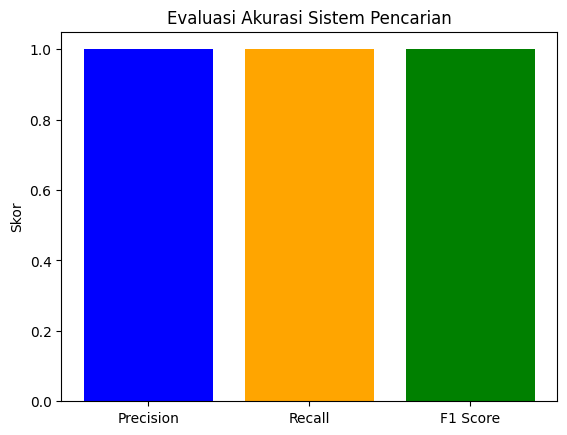

In [35]:
import matplotlib.pyplot as plt

# Contoh visualisasi metrik
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.title("Evaluasi Akurasi Sistem Pencarian")
plt.ylabel("Skor")
plt.show()
